In [25]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [26]:
data_dir = Path('../../data')

### Average disstance between random B vectors

In [27]:
# transposing, so we have columns as features and rows as sample vectors
B_df = pd.read_csv(data_dir / 'plierResult/B.csv').transpose()
B_df.shape

(4293, 258)

In [4]:
sample_size = 100

a = B_df.sample(sample_size)
b = B_df.sample(sample_size)

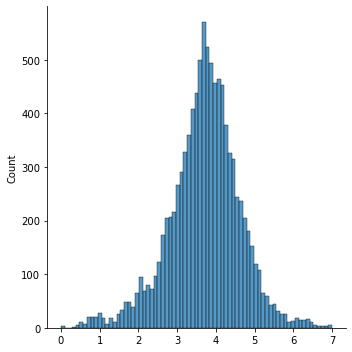

In [5]:
dists = scipy.spatial.distance.cdist(a, b).flatten()
sns.displot(dists)

#### Using Cosine Similarity

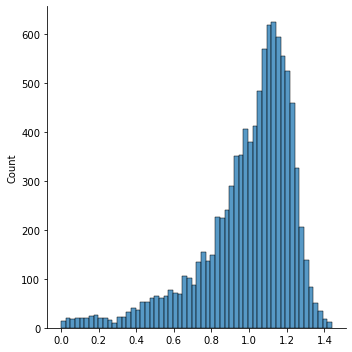

In [6]:
dists = scipy.spatial.distance.cdist(a, b, metric='cosine').flatten()
sns.displot(dists)

<AxesSubplot:>

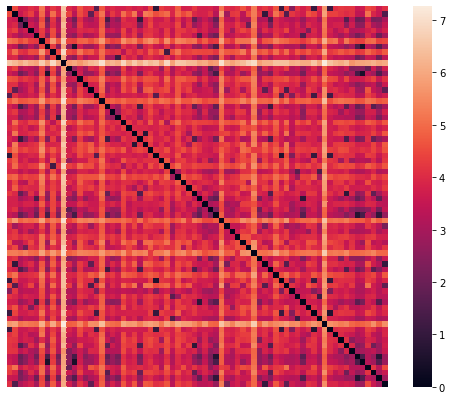

In [7]:
tmpa_a = B_df.sample(70)

fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(tmpa_a, tmpa_a),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

## Trying to find back the random set of B vectors using regression

### Loading Y and Z and verifying we've got the right vectors
#### Y is a source data. Y ≈ ZB

In [9]:
# transposing, so we have columns as features and rows as sample vectors
Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
Y_df.shape

(4293, 55904)

In [10]:
Z_df = pd.read_csv(data_dir / 'plierResult/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 258)

In [11]:
Z_genes = Z_df.index
print(f'{len(Z_genes)} genes in Z matrix')
z_in_y = Z_genes.isin(Y_df.columns).sum()
f'{z_in_y * 100 / len(Z_genes)}% of them in matrix Y'

5900 genes in Z matrix


'100.0% of them in matrix Y'

#### Selecting only 5900 genes present in matrix Z from original data

In [12]:
Y_df = Y_df[Z_genes]
Y_df.shape

(4293, 5900)

In [48]:
regr_subset_size = 25

target_b_inds = random.choices(range(len(B_df)), k=regr_subset_size)
target_b_vectors = B_df.iloc[target_b_inds].values
target_b_vectors.shape

(25, 258)

In [49]:
target_y_vectors = Y_df.iloc[target_b_inds].values
target_y_vectors.shape

(25, 5900)

### What is our reconstruction loss? Do we have the right vectors for regression?

In [50]:
target_ys = Y_df.iloc[target_b_inds]
target_ys.shape

(25, 5900)

In [51]:
assert sum(target_ys.index != B_df.iloc[target_b_inds].index) == 0

In [52]:
Z_mat.shape, target_b_vectors.shape

((5900, 258), (25, 258))

We need to transpose B matrics, so one column is a sample embedding vector

In [53]:
y_hat = np.matmul(Z_mat, target_b_vectors.transpose()).transpose()

In [148]:
y_hat.shape

(25, 5900)

<AxesSubplot:>

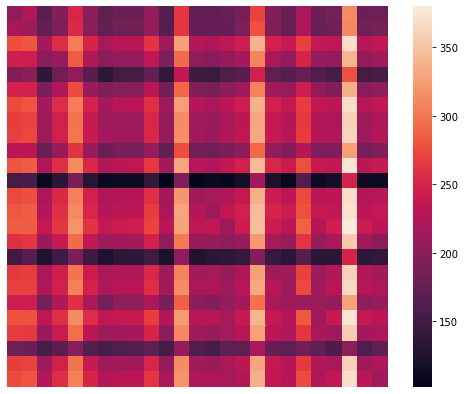

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(target_y_vectors, y_hat),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### We've got a complete mess. Target values don't look like those we've got at all

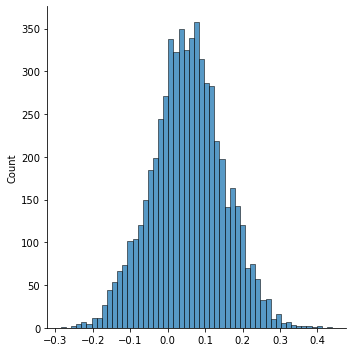

In [110]:
sns.displot(y_hat.mean(axis=0))

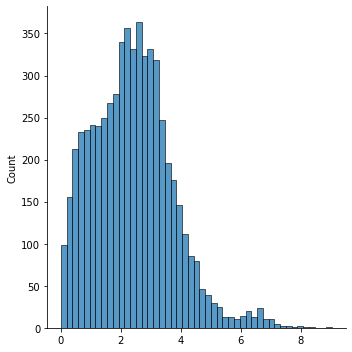

In [111]:
sns.displot(target_y_vectors.mean(axis=0))

### Looks like the source matrix was normalized before running the PLIER. Let's try to do the same on our data

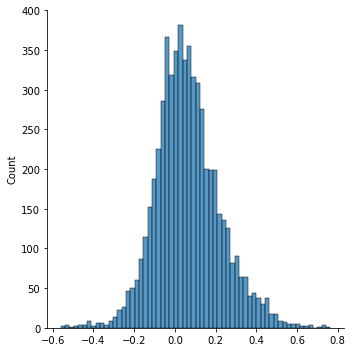

In [117]:
# computing normalization values on full dataset
per_gene_mean = Y_df.mean().values
target_y_norm = target_y_vectors - per_gene_mean

sns.displot(target_y_norm.mean(axis=0))

<AxesSubplot:>

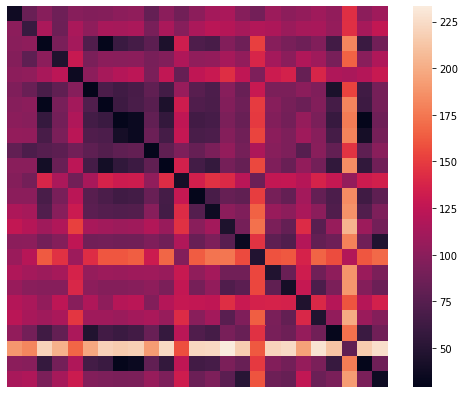

In [119]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(target_y_norm, y_hat),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### This looks much better!

In [121]:
per_gene_std = Y_df.std().values
target_y_norm = (target_y_vectors - per_gene_mean) / per_gene_std

<AxesSubplot:>

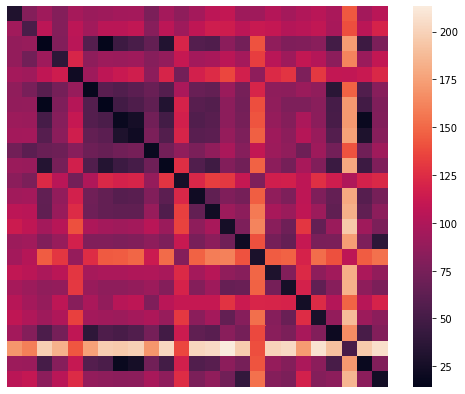

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(target_y_norm, y_hat),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

## Using regression to find the B that will produce vector close to target_y_norm

In [176]:
from numpy.linalg import inv

In [184]:
X = Z_mat

In [204]:
# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b = inv(X.T.dot(X)).dot(X.T).dot(target_y_norm.T)
b.shape

(258, 25)

<AxesSubplot:>

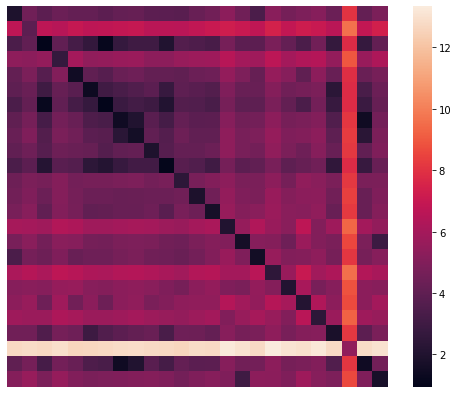

In [205]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(b.T, target_b_vectors),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

In [206]:
y_hat_hat = Z_mat.dot(b).transpose()
y_hat_hat.shape

(25, 5900)

<AxesSubplot:>

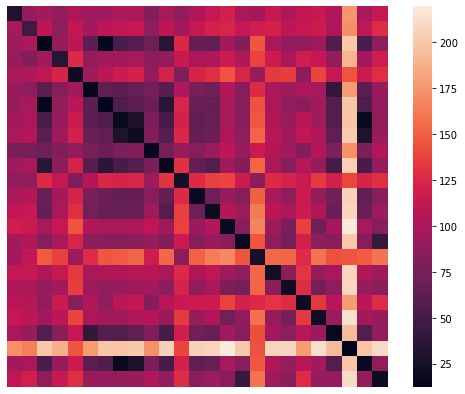

In [207]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

sns.heatmap(scipy.spatial.distance.cdist(target_y_norm, y_hat_hat),
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])